# **Edge-Centric Model Training**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
print(f"{'torch:':<20} {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{'device:':<20} {device}")

import numpy as np
import math
import random
print(f"{'numpy:':<20} {np.__version__}")

import matplotlib
import matplotlib.pyplot as plt
print(f"{'matplotlib:':<20} {matplotlib.__version__}")

import seaborn as sns

from tqdm import tqdm

import logger
print(f"{'logger (custom):':<20} loaded")

from Models.Architectures.edgeGNN import EdgeCentricNetwork
from DataManagement.data import StaticFinancialDataset, TemporalFinancialDataset

from Models.financials.evaluator import GARCHBaselineEvaluator

from Models.Losses.high_variance import VolatilitySpikeLoss, ExponentialDistanceWeightedLoss

torch:               2.7.1+cu118
device:              cuda
numpy:               2.2.4
matplotlib:          3.10.3
logger (custom):     loaded


In [3]:
window = 30
temporal_dataset = TemporalFinancialDataset(window_size=window)
static_dataset = StaticFinancialDataset()

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1256 rows with data
XLF: 1256 rows with data
XLE: 1256 rows with data
XLV: 1256 rows with data
XLI: 1256 rows with data
XLP: 1256 rows with data
XLY: 1256 rows with data
XLU: 1256 rows with data
XLB: 1256 rows with data
XLRE: 1256 rows with data
XLC: 1256 rows with data
✓ All sectors have same number of dates
Common dates: 1256
XLK len: 1256
XLF len: 1256
XLE len: 1256
XLV len: 1256
XLI len: 1256
XLP len: 1256
XLY len: 1256
XLU len: 1256
XLB len: 1256
XLRE len: 1256
XLC len: 12

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  feature_data = torch.tensor(data=feature_data, dtype=torch.float32).transpose(0, 1)
c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*********             18%                       ]  2 of 11 completed

Any NaNs in features? tensor(False)
Any Infs in features? tensor(False)


[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1256 rows with data
XLF: 1256 rows with data
XLE: 1256 rows with data
XLV: 1256 rows with data
XLI: 1256 rows with data
XLP: 1256 rows with data
XLY: 1256 rows with data
XLU: 1256 rows with data
XLB: 1256 rows with data
XLRE: 1256 rows with data
XLC: 1256 rows with data
✓ All sectors have same number of dates
Common dates: 1256
XLK len: 1256
XLF len: 1256
XLE len: 1256
XLV len: 1256
XLI len: 1256
XLP len: 1256
XLY len: 1256
XLU len: 1256
XLB len: 1256
XLRE len: 1256
XLC len: 12

In [4]:
dataset = temporal_dataset

In [ ]:
num_samples = len(dataset)

train_split = 0.9

train_size = int(train_split * num_samples)
test_size = num_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
test_dataset = torch.utils.data.Subset(dataset, list(range(train_size, num_samples)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_batch = next(iter(train_loader))
print(f"Batch Feature Dim: {sample_batch[0].shape}")
print(f"Batch Target Dim: {sample_batch[1].shape}")
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

print(dataset.features.shape)

Batch Feature Dim: torch.Size([32, 30, 11, 89])
Batch Target Dim: torch.Size([32, 11])
Train Dataset Length: 1076
Test Dataset Length: 120
torch.Size([1225, 11, 89])


In [6]:
static = False
temporal = True
model = EdgeCentricNetwork(
    num_nodes=dataset.num_sectors,
    edge_dim=16,
    node_dim=dataset.features.shape[2],
    static=static,
    temporal=temporal,
    window=window,
    complex=False)

model.to(device)

model

EdgeCentricNetwork(
  (edge_updater): TemporalEdgeUpdater(
    (sigmoid): Sigmoid()
    (tanh): Tanh()
    (dropout_10): Dropout(p=0.1, inplace=False)
    (dropout_20): Dropout(p=0.2, inplace=False)
    (temporal_layers): ModuleList(
      (0): GRU(178, 64, batch_first=True)
      (1): GRU(64, 16, batch_first=True)
    )
    (refined_edges): Sequential(
      (0): Linear(in_features=16, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): GELU(approximate='none')
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): GELU(approximate='none')
      (8): Dropout(p=0.05, inplace=False)
      (9): Linear(in_features=64, out_features=16, bias=True)
      (10): GELU(approximate='none')
    )
  )
  (regression): EdgetoNodeRegressionBlock(
    (regression): Sequential(
      (0): Linear(in_features=176, out_features=512, bias=

In [ ]:
saved_model = EdgeCentricNetwork(
    num_nodes=dataset.num_sectors, 
    edge_dim=32, 
    node_dim=dataset.features.shape[2], 
    static=False, 
    temporal=True, 
    window=14,
    complex=True)

saved_model.load_state_dict(torch.load(r"Models/save/complex/GRUnewTemporalEdgeCentricGNN_state.pth"))
saved_model.to(device)

In [7]:
epoch_losses = []
batch_losses = []

In [8]:
LR = 3.25e-5
optimizer = optim.Adam(params=model.parameters(), lr=LR)
criterion = VolatilitySpikeLoss()

epoch_num = 100

GREEN = '\033[92m'
RESET = '\033[0m'
bar_format = "{l_bar}" + GREEN + "{bar}" + RESET + "{r_bar}"

model.train()

torch.cuda.empty_cache()
for epoch in range(epoch_num):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epoch_num}]", leave=True, bar_format=bar_format)

    for features, targets in loop:
        features = features.to(device)
       
        targets = targets.unsqueeze(2).to(device)

        optimizer.zero_grad()
        
        output = model(features)
        
        loss = criterion(output, targets)
        
        loss.backward() 
        optimizer.step()

        batch_losses.append(loss.item())
        epoch_loss += loss.item()

        loop.set_postfix(loss=f"{loss.item():.6f}")

    epoch_losses.append(epoch_loss / len(train_loader))
    torch.cuda.empty_cache()

Epoch [100/100]: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s, loss=2.158859]


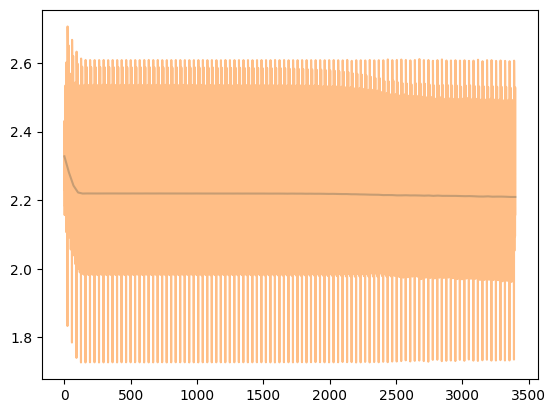

In [15]:
epoch_time_losses = np.linspace(start=0, stop=len(batch_losses) - 1, num=len(epoch_losses))
batch_time_losses = np.linspace(start=0, stop=len(batch_losses) - 1, num=len(batch_losses))

plt.plot(epoch_time_losses, epoch_losses, alpha=0.5)
plt.plot(batch_time_losses, batch_losses, alpha=0.5)

In [20]:
# Model Save lol forgot this before
torch.save(model.state_dict(), "Models/save/non_complex/GRUTemporalEdgeCentricGNN_v2_state.pth")
torch.save(model, "Models/save/non_complex/GRUTemporalEdgeCentricGNN_v2_full.pth")

In [22]:
# Inference
model.eval()

evaluation_loss = nn.L1Loss()
test_loss = 0.0
test_losses = []
outputs = []
truths = []

for features, targets in test_loader:

    features = features.to(device)
    targets = targets.to(device)
    #.unsqueeze(3)
    output = model(features).squeeze(2)

    outputs.append(output.cpu().flatten())
    truths.append(targets.cpu().flatten())

    #print(f"Target Shape: {targets.shape}")
    #print(f"Output Shape: {outputs.shape}")
    loss = evaluation_loss(output, targets)
    
    test_losses.append(loss.item())

    test_loss += loss.item()

print(f"Total Test Loss: {test_loss}")

all_outputs = torch.cat(outputs).detach().numpy()
all_truths = torch.cat(truths).detach().numpy()

outputs_tensor = torch.cat(outputs)
truths_tensor = torch.cat(truths)

overall_loss = evaluation_loss(outputs_tensor, truths_tensor)
print(f"Average Test Loss (per sample): {overall_loss.item():.6f}")

print(f"All Outputs Shape: {all_outputs.shape}")
print(f"All Truths Shape: {all_truths.shape}")

Total Test Loss: 0.7223463207483292
Average Test Loss (per sample): 0.180638
All Outputs Shape: (1320,)
All Truths Shape: (1320,)


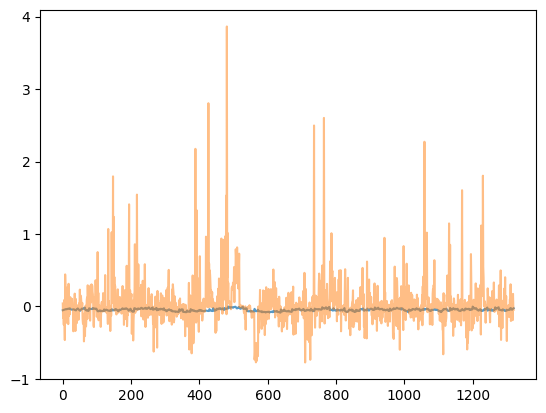

In [23]:
x = np.linspace(start=0, stop=all_outputs.shape[0], num=all_outputs.shape[0])
plt.plot(x, all_outputs, alpha=0.75)
plt.plot(x, all_truths, alpha=0.5)

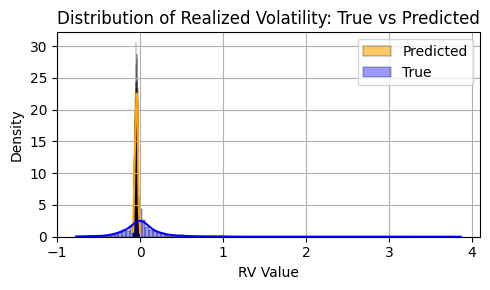

In [24]:
plt.figure(figsize=(5, 3))

sns.histplot(all_outputs, kde=True, color='orange', stat='density', label='Predicted', alpha=0.6, bins=100)
sns.histplot(all_truths, kde=True, color='blue', stat='density', label='True', alpha=0.4, bins=100)

plt.title("Distribution of Realized Volatility: True vs Predicted")
plt.xlabel("RV Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

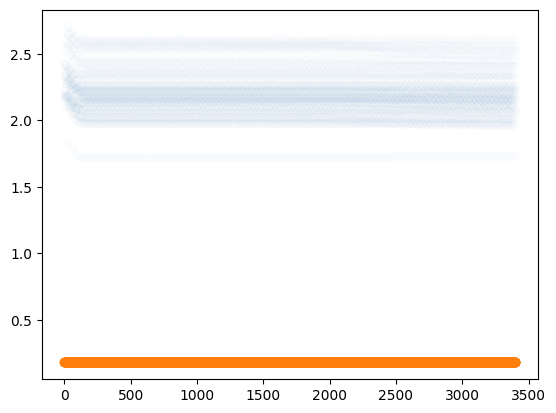

In [25]:
average_test_loss = [sum(test_losses) / len(test_losses) for i in range(len(batch_losses))]
new_x_plane = np.linspace(start=0, stop=len(batch_losses) - 1, num=len(batch_losses))

plt.scatter(new_x_plane, batch_losses, alpha=0.01)
plt.scatter(new_x_plane, average_test_loss)

In [26]:
# Fun Statistic Checker Code 

count_bound = 0
count_no_bound = 0

within_bounds_outputs = []
within_bounds_truths = []

max_truth, min_truth = np.max(all_truths), np.min(all_truths)
print(f"Max Truth Val: {max_truth}")
print(f"Min Truth Val: {min_truth}")

for idx, pred in enumerate(all_outputs):
    if pred >= -1 and pred <= 1 and all_truths[idx] >= -1 and all_truths[idx] <= 1:
        count_bound += 1
        within_bounds_outputs.append(all_outputs[idx])
        within_bounds_truths.append(all_truths[idx])
    else:
        count_no_bound+=1

print(f"Within Bound -1 to 1: {count_bound}")
print(f"Outside of -1 to 1: {count_no_bound}")

Max Truth Val: 3.8637616634368896
Min Truth Val: -0.7724792957305908
Within Bound -1 to 1: 1299
Outside of -1 to 1: 21


C:\Users\lordw\AppData\Local\Temp\ipykernel_39372\380006448.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


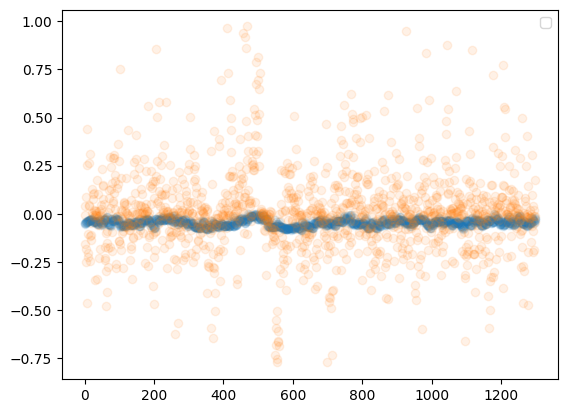

In [27]:
x = np.linspace(start=0, stop=len(within_bounds_outputs) - 1, num=len(within_bounds_outputs))

plt.scatter(x, within_bounds_outputs, alpha=0.1)
#plt.scatter(x, all_truths, alpha=0.05)
plt.scatter(x, within_bounds_truths, alpha=0.1)

plt.legend()

## Training Baseline for GARCH

In [28]:
garch_temporal_dataset = TemporalFinancialDataset(window_size=252)

garch_dataset_len = len(garch_temporal_dataset)

train_prop = 0.8

train_length = int(garch_dataset_len * train_prop)
test_length = garch_dataset_len - train_length

train_indices = np.linspace(start=0, stop=train_length-1, num=train_length)
test_indices = np.linspace(start=train_length, stop=train_length + test_length - 1, num=test_length)

train_dataset = Subset(dataset=garch_temporal_dataset, indices=train_indices)
test_dataset = Subset(dataset=garch_temporal_dataset, indices=test_indices)

evaluator = GARCHBaselineEvaluator(
    returns_dict=garch_temporal_dataset.returns_dict,
    y_true_dict=garch_temporal_dataset.volatility_dict,
    horizon=1,
    window=252
)

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*************         27%                       ]  3 of 11 completed

[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1256 rows with data
XLF: 1256 rows with data
XLE: 1256 rows with data
XLV: 1256 rows with data
XLI: 1256 rows with data
XLP: 1256 rows with data
XLY: 1256 rows with data
XLU: 1256 rows with data
XLB: 1256 rows with data
XLRE: 1256 rows with data
XLC: 1256 rows with data
✓ All sectors have same number of dates
Common dates: 1256
XLK len: 1256
XLF len: 1256
XLE len: 1256
XLV len: 1256
XLI len: 1256
XLP len: 1256
XLY len: 1256
XLU len: 1256
XLB len: 1256
XLRE len: 1256
XLC len: 12

In [29]:
window_size = 252
num_sectors = garch_temporal_dataset.num_sectors

rolling_preds = {sector: [] for sector in range(num_sectors)}
true_vals = {sector: [] for sector in range(num_sectors)}

# Only iterate through valid training indices
max_train_idx = train_length - 1  # Last valid training index
start_idx = window_size - 1  # First index where you have full window

for i in range(start_idx, max_train_idx + 1):
    _, targets = garch_temporal_dataset[i]
    
    for sector in range(num_sectors):
        windowed_returns = garch_temporal_dataset.returns_dict[sector].values[i-window_size+1:i+1]
        
        try:
            pred = evaluator._fit_garch(windowed_returns)
            rolling_preds[sector].append(pred)
            true_vals[sector].append(garch_temporal_dataset.volatility_dict[sector].values[i])
        except Exception as e:
            print(f"Error on sector {sector}, index {i}: {e}")

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001732. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [32]:
# Converts to arrays and compute loss
total_loss = 0.0
for sector in range(num_sectors):
    preds = np.array(rolling_preds[sector])
    y_true = np.array(true_vals[sector])
    min_len = min(len(preds), len(y_true))

    loss = evaluation_loss(
        torch.tensor(preds[-min_len:], dtype=torch.float32),
        torch.tensor(y_true[-min_len:], dtype=torch.float32)
    ).item()
    total_loss += loss
    print(f"Sector {sector}: Smooth L1 Loss = {loss:.4f}")
print(f"Sector Loss Average: {total_loss / num_sectors}")

Sector 0: Smooth L1 Loss = 0.1510
Sector 1: Smooth L1 Loss = 0.1683
Sector 2: Smooth L1 Loss = 0.1635
Sector 3: Smooth L1 Loss = 0.1552
Sector 4: Smooth L1 Loss = 0.1760
Sector 5: Smooth L1 Loss = 0.1839
Sector 6: Smooth L1 Loss = 0.1618
Sector 7: Smooth L1 Loss = 0.1603
Sector 8: Smooth L1 Loss = 0.1576
Sector 9: Smooth L1 Loss = 0.1817
Sector 10: Smooth L1 Loss = 0.1540
Sector Loss Average: 0.16484265571290796


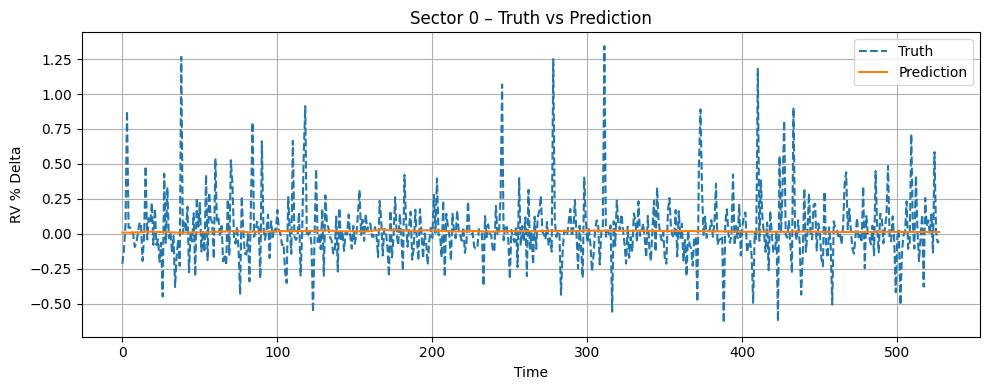

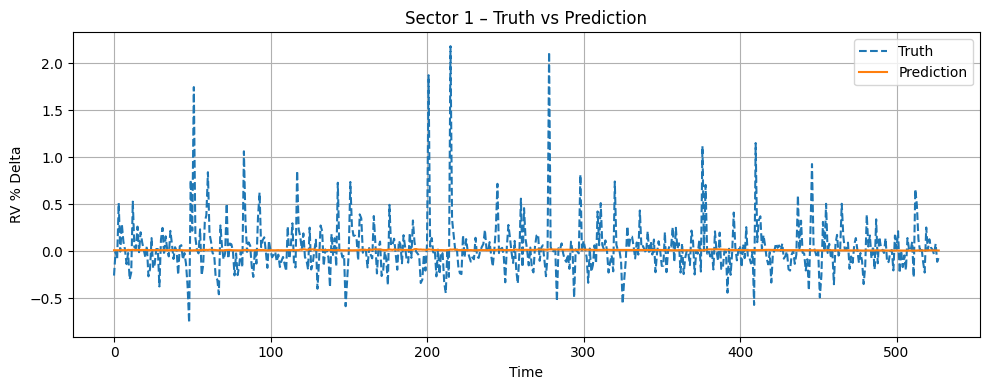

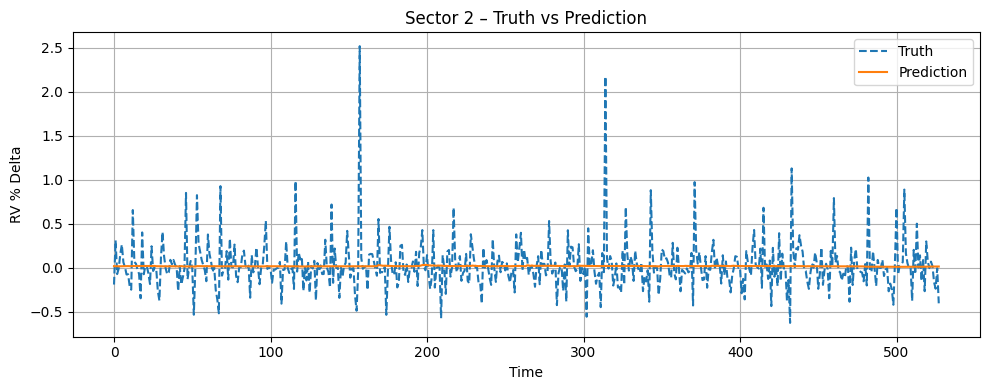

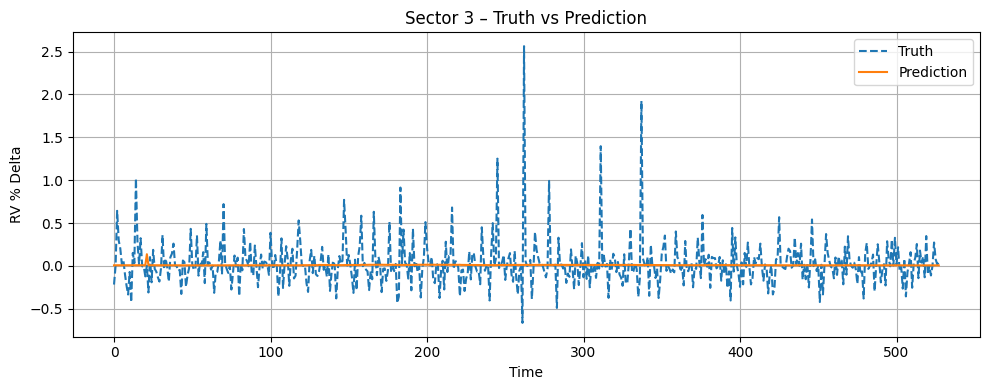

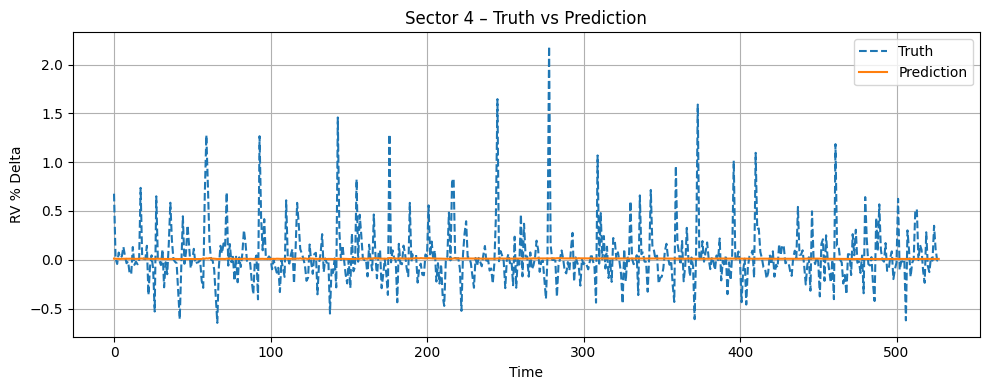

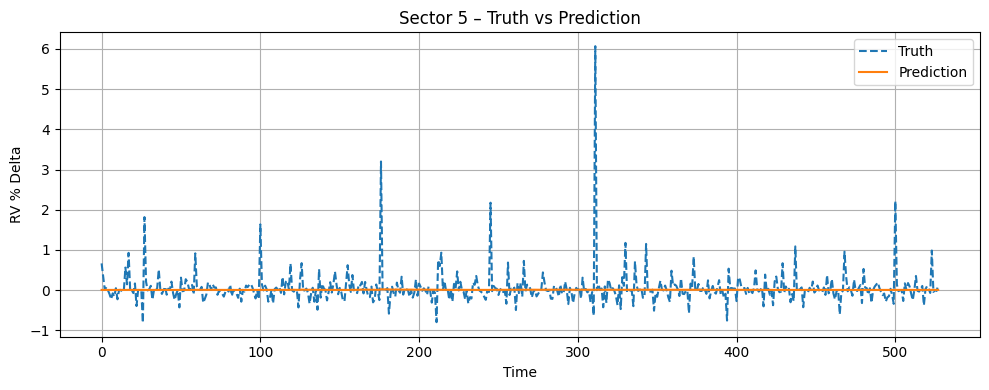

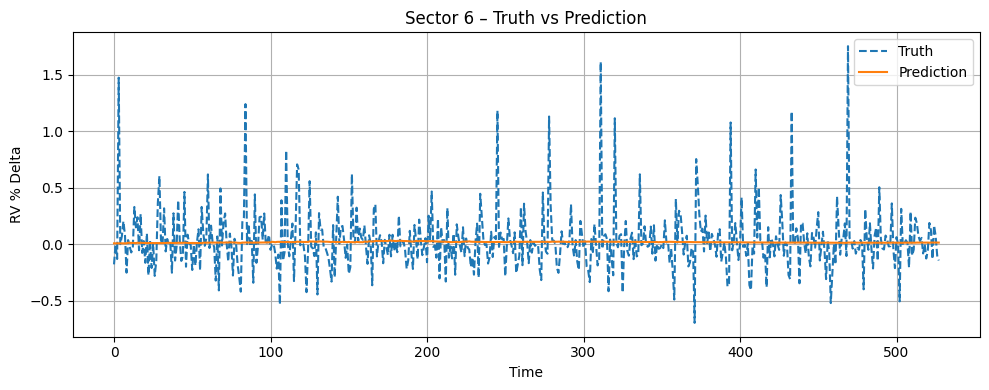

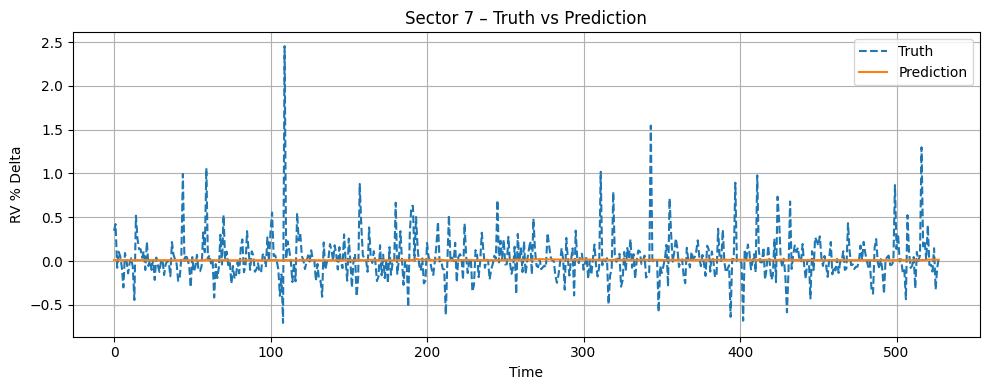

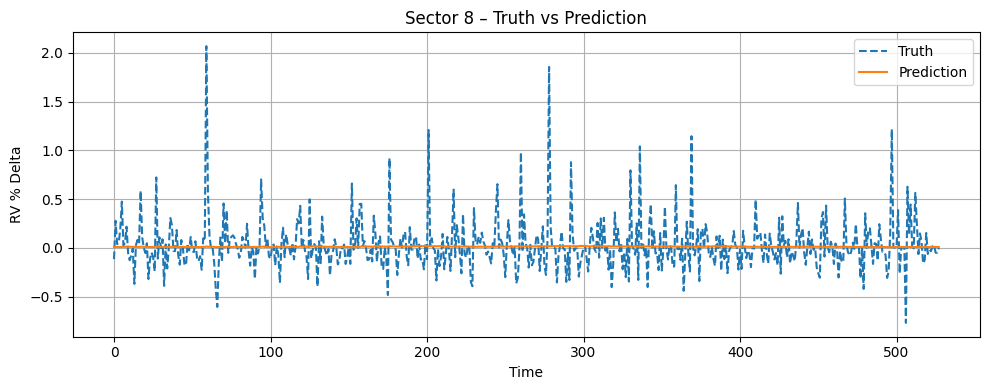

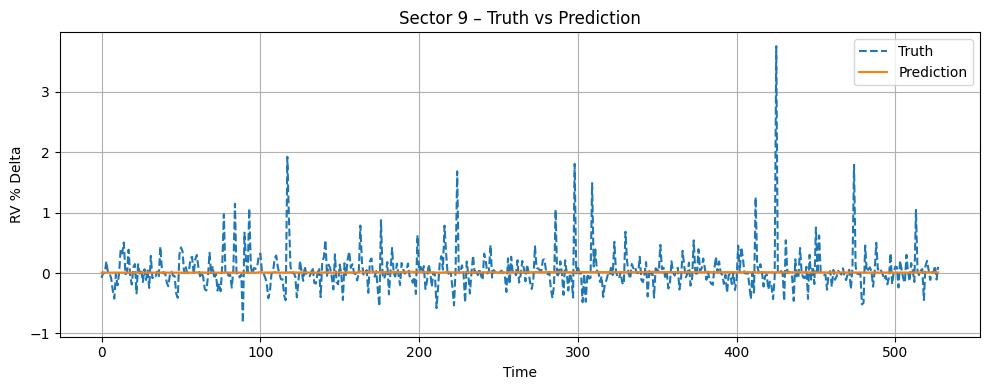

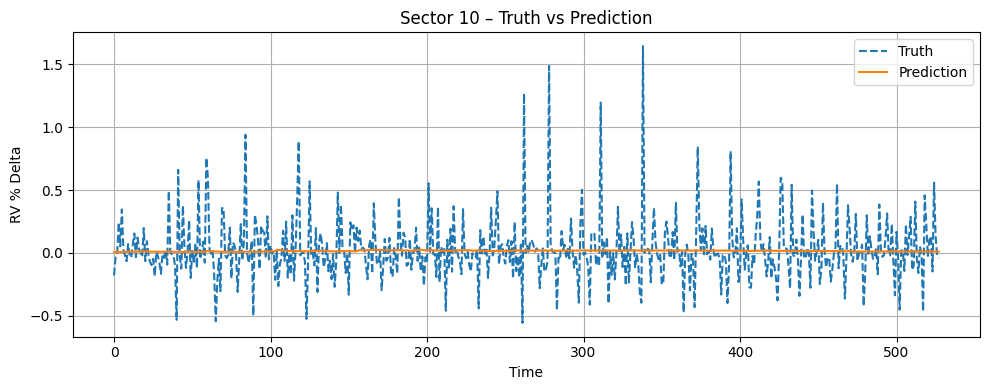

In [33]:
for sector in range(num_sectors):
    preds = np.array(rolling_preds[sector])
    y_true = np.array(true_vals[sector])
    min_len = min(len(preds), len(y_true))

    plt.figure(figsize=(10, 4))
    plt.plot(y_true[-min_len:], label="Truth", linestyle='--')
    plt.plot(preds[-min_len:], label="Prediction")
    plt.title(f"Sector {sector} – Truth vs Prediction")
    plt.xlabel("Time")
    plt.ylabel("RV % Delta")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [34]:
def directional_loss(y_pred, y_true, alpha=1.0):
    
    pred_change = y_pred[1:] - y_pred[:-1]
    true_change = y_true[1:] - y_true[:-1]
    
    direction_agreement = torch.sign(pred_change) * torch.sign(true_change)
    
    directional_penalty = torch.mean(torch.relu(-direction_agreement))
    
    return alpha * directional_penalty